<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/CCAP_UNET_Fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio scikit-image tensorflow keras gdown
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.2 MB/s eta 0:00:00


In [3]:
import rasterio
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import glob
import gdown
import zipfile
from skimage.transform import resize
from tensorflow.keras import layers
import random
from keras.utils import to_categorical
from skimage.util import random_noise
from scipy import ndimage
from scipy.ndimage import label as nd_label
import cv2
from scipy.ndimage import generic_filter
from keras.models import load_model
from scipy.stats import mode
from keras.utils import Sequence, to_categorical
import rasterio.plot
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# Additional code can be added here if needed

In [4]:
!mkdir /content/image_subsets

In [5]:
# get the .zip files from my drive
zip_files = glob.glob('/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/*.zip')

# send the .zip files to a new path
extract_zip = '/content/image_subsets'

for zip_file in zip_files:
  base_name = os.path.basename(zip_file)[:-4]
  unzip_dir = os.path.join(extract_zip, base_name)
  os.makedirs(unzip_dir, exist_ok=True)
  !unzip -q "$zip_file" -d "$unzip_dir"

In [6]:
# Get all .csv files
csv_files = glob.glob('/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/*.csv')

csv_list = []
for csv_file in csv_files:
    # Get the base name of the zip file (without .zip extension)
    base_name = os.path.basename(csv_file)[:-4]

    csv_loc = os.path.join(extract_zip, base_name)
    base_csv = pd.read_csv(csv_file)
    base_csv['subset'] = base_name
    csv_list.append(base_csv)

index_csv = pd.concat(csv_list, ignore_index=True)

In [7]:
csv_files

['/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Kauai10_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Molokai_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Kauai_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Molokai10_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Niihau10_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Maui_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Maui10_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Oahu_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Oahu11_subset.csv',
 '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Lanai11_subset.csv',
 '/content/drive/

In [8]:
index_csv

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,label,percent,tif_name,subset
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,13,0.000919,8705_513.tif,Kauai10_subset
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,13,0.033161,9217_513.tif,Kauai10_subset
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,13,0.000130,13313_513.tif,Kauai10_subset
3,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,14,0.000137,13313_513.tif,Kauai10_subset
4,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,15,0.003502,13313_513.tif,Kauai10_subset
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,15,0.005005,1537_10241.tif,Niihau_subset
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,14,0.003483,2049_10241.tif,Niihau_subset
5257,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,15,0.003937,2049_10241.tif,Niihau_subset
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,15,0.002464,2049_10753.tif,Niihau_subset


In [9]:
import shutil
# Define the file path where you want to save the CSV file
csv_file_path = '/content/index_csv.csv'
index_csv.to_csv(csv_file_path, index=False)
print(f"DataFrame exported to {csv_file_path}")

# Define the destination folder in Google Drive
drive_folder = '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/'
shutil.copy(csv_file_path, drive_folder)
print(f'CSV file moved to Google Drive: {drive_folder}')

DataFrame exported to /content/index_csv.csv
CSV file moved to Google Drive: /content/drive/MyDrive/wetland_unet/UNET_Image_Chips/


In [10]:
print(index_csv.groupby('label')['percent'].sum())

label
13    415.118298
14     96.488571
15     31.941513
16      5.456203
17      3.642021
18      4.176750
Name: percent, dtype: float64


In [11]:
print(index_csv.groupby('label')['percent'].count())

label
13    1694
14    1395
15    1576
16     203
17     207
18     185
Name: percent, dtype: int64


In [12]:
print(index_csv.groupby('label')['percent'].sum()/index_csv.groupby('label')['percent'].count())

label
13    0.245052
14    0.069167
15    0.020267
16    0.026878
17    0.017594
18    0.022577
Name: percent, dtype: float64


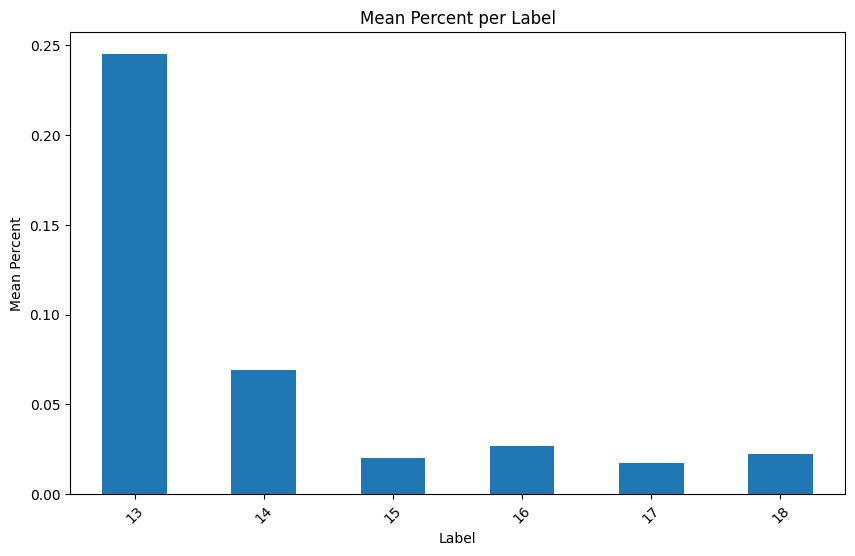

In [13]:
# Calculate the mean 'percent' values per 'label'
mean_percent_per_label = index_csv.groupby('label')['percent'].mean()

# Plot a bar chart
plt.figure(figsize=(10, 6))
mean_percent_per_label.plot(kind='bar')
plt.title('Mean Percent per Label')
plt.xlabel('Label')
plt.ylabel('Mean Percent')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [14]:
# Group by 'subset' (folder) and 'label', then count the occurrences
folder_label_counts = index_csv.groupby(['subset', 'label']).size().unstack(fill_value=0)

# Find the label with the maximum count in each folder
most_common_label_per_folder = folder_label_counts.idxmax(axis=1)

print("Folder with the most common label for each label:")
print(most_common_label_per_folder)


Folder with the most common label for each label:
subset
HawaiI_2005_001_subset    13
Hawaii_2005_002_subset    18
Hawaii_2005_004_subset    15
Hawaii_2005_005_subset    15
Hawaii_2005_006_subset    18
Hawaii_2005_007_subset    13
Hawaii_2005_008_subset    15
Kauai10_subset            15
Kauai_subset              15
Lanai11_subset            15
Lanai_subset              15
Maui10_subset             13
Maui_subset               13
Molokai10_subset          13
Molokai_subset            13
Niihau10_subset           15
Niihau_subset             14
Oahu11_subset             15
Oahu_subset               15
dtype: int64


In [15]:
index_csv.groupby(['tif_name', 'subset']).size().reset_index(name='Count')

,tif_name,subset,Count
0,10241_1.tif,HawaiI_2005_001_subset,1
1,10241_10241.tif,Oahu11_subset,1
2,10241_1025.tif,HawaiI_2005_001_subset,1
3,10241_1025.tif,Kauai10_subset,2
4,10241_1025.tif,Kauai_subset,2
...,...,...,...
2732,9729_8193.tif,Kauai_subset,1
2733,9729_8705.tif,Hawaii_2005_008_subset,1
2734,9729_9217.tif,Hawaii_2005_008_subset,3
2735,9729_9729.tif,Oahu11_subset,2


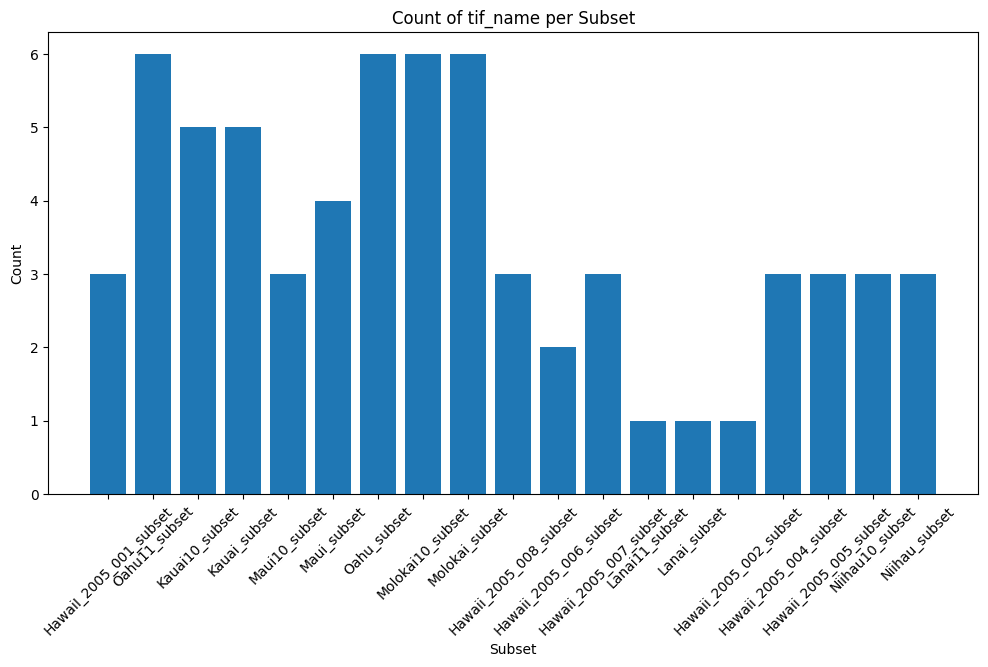

In [16]:
# Group by 'tif_name' and 'subset' and count occurrences, then reset the index
count_per_subset = index_csv.groupby(['tif_name', 'subset']).size().reset_index(name='Count')

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(count_per_subset['subset'], count_per_subset['Count'])
plt.title('Count of tif_name per Subset')
plt.xlabel('Subset')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [17]:
unique_rows_df = index_csv.groupby(['label', 'tif_name', 'subset']).size().reset_index(name='Count')

In [18]:
unique_rows_df

,label,tif_name,subset,Count
0,13,10241_1025.tif,Kauai10_subset,1
1,13,10241_1025.tif,Kauai_subset,1
2,13,10241_10753.tif,Maui10_subset,1
3,13,10241_10753.tif,Maui_subset,1
4,13,10241_11265.tif,Maui10_subset,1
...,...,...,...,...
5255,18,9217_6145.tif,Molokai_subset,1
5256,18,9729_5633.tif,Molokai10_subset,1
5257,18,9729_5633.tif,Molokai_subset,1
5258,18,9729_6145.tif,Molokai10_subset,1


In [19]:
unique_rows_df = index_csv.groupby(['tif_name', 'label', 'subset']).agg({'percent': 'mean'}).reset_index()

In [20]:
unique_rows_df

,tif_name,label,subset,percent
0,10241_1.tif,15,HawaiI_2005_001_subset,0.003197
1,10241_10241.tif,15,Oahu11_subset,0.002010
2,10241_1025.tif,13,Kauai10_subset,0.054741
3,10241_1025.tif,13,Kauai_subset,0.021980
4,10241_1025.tif,15,HawaiI_2005_001_subset,0.000404
...,...,...,...,...
5255,9729_9217.tif,15,Hawaii_2005_008_subset,0.140572
5256,9729_9729.tif,13,Oahu11_subset,0.012516
5257,9729_9729.tif,13,Oahu_subset,0.012730
5258,9729_9729.tif,15,Oahu11_subset,0.002750


In [21]:
# Remove duplicates from unique_rows_df
cleaned_unique_rows_df = unique_rows_df.drop_duplicates(subset=['tif_name', 'label', 'subset'])

# View the cleaned DataFrame
print(cleaned_unique_rows_df)

             tif_name  label                  subset   percent
0         10241_1.tif     15  HawaiI_2005_001_subset  0.003197
1     10241_10241.tif     15           Oahu11_subset  0.002010
2      10241_1025.tif     13          Kauai10_subset  0.054741
3      10241_1025.tif     13            Kauai_subset  0.021980
4      10241_1025.tif     15  HawaiI_2005_001_subset  0.000404
...               ...    ...                     ...       ...
5255    9729_9217.tif     15  Hawaii_2005_008_subset  0.140572
5256    9729_9729.tif     13           Oahu11_subset  0.012516
5257    9729_9729.tif     13             Oahu_subset  0.012730
5258    9729_9729.tif     15           Oahu11_subset  0.002750
5259    9729_9729.tif     15             Oahu_subset  0.002750

[5260 rows x 4 columns]


In [22]:
# Calculate the number of dropped duplicates
num_dropped_duplicates = len(unique_rows_df) - len(cleaned_unique_rows_df)

# Print the number of dropped duplicates
print(f"Number of dropped duplicates: {num_dropped_duplicates}")


Number of dropped duplicates: 0


In [23]:
unique_rows_df

,tif_name,label,subset,percent
0,10241_1.tif,15,HawaiI_2005_001_subset,0.003197
1,10241_10241.tif,15,Oahu11_subset,0.002010
2,10241_1025.tif,13,Kauai10_subset,0.054741
3,10241_1025.tif,13,Kauai_subset,0.021980
4,10241_1025.tif,15,HawaiI_2005_001_subset,0.000404
...,...,...,...,...
5255,9729_9217.tif,15,Hawaii_2005_008_subset,0.140572
5256,9729_9729.tif,13,Oahu11_subset,0.012516
5257,9729_9729.tif,13,Oahu_subset,0.012730
5258,9729_9729.tif,15,Oahu11_subset,0.002750


In [24]:
# Define the file path where you want to save the CSV file
csv_file_path = '/content/unique_rows_df.csv'
unique_rows_df.to_csv(csv_file_path, index=False)
print(f"DataFrame exported to {csv_file_path}")

# Define the destination folder in Google Drive
drive_folder = '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/'
shutil.copy(csv_file_path, drive_folder)
print(f'CSV file moved to Google Drive: {drive_folder}')

DataFrame exported to /content/unique_rows_df.csv
CSV file moved to Google Drive: /content/drive/MyDrive/wetland_unet/UNET_Image_Chips/


In [25]:
# # Aggregate the 'percent' values for duplicate 'tif_name' entries
# agg_df = unique_rows_df.groupby(['tif_name', 'label']).agg({'percent': 'mean'}).reset_index()

# # Pivot the data to create columns for each unique 'label'
# pivot_df = agg_df.pivot(index='tif_name', columns='label', values='percent').reset_index()

# # Fill NaN values with 0 if needed
# pivot_df = pivot_df.fillna(0)

# # Merge with the original dataset to keep the other relevant information
# summary_df = index_csv[['tif_name', 'x_end', 'y_end', 'x_org', 'y_org',  'id', 'xmin', 'xmax', 'ymin', 'ymax', 'subset']].drop_duplicates().merge(pivot_df, on='tif_name')

# summary_df

In [26]:
unique_rows_df

,tif_name,label,subset,percent
0,10241_1.tif,15,HawaiI_2005_001_subset,0.003197
1,10241_10241.tif,15,Oahu11_subset,0.002010
2,10241_1025.tif,13,Kauai10_subset,0.054741
3,10241_1025.tif,13,Kauai_subset,0.021980
4,10241_1025.tif,15,HawaiI_2005_001_subset,0.000404
...,...,...,...,...
5255,9729_9217.tif,15,Hawaii_2005_008_subset,0.140572
5256,9729_9729.tif,13,Oahu11_subset,0.012516
5257,9729_9729.tif,13,Oahu_subset,0.012730
5258,9729_9729.tif,15,Oahu11_subset,0.002750


In [27]:
# original
# pivot_df = unique_rows_df.pivot(index='tif_name', columns='label', values='percent').reset_index()
# my version
pivot_df = unique_rows_df.pivot(index=['tif_name', 'subset'], columns='label', values='percent').reset_index()

In [28]:
pivot_df

label,tif_name,subset,13,14,15,16,17,18
0,10241_1.tif,HawaiI_2005_001_subset,NaN,NaN,0.003197,NaN,NaN,NaN
1,10241_10241.tif,Oahu11_subset,NaN,NaN,0.002010,NaN,NaN,NaN
2,10241_1025.tif,HawaiI_2005_001_subset,NaN,NaN,0.000404,NaN,NaN,NaN
3,10241_1025.tif,Kauai10_subset,0.054741,NaN,0.010788,NaN,NaN,NaN
4,10241_1025.tif,Kauai_subset,0.021980,NaN,0.040855,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2732,9729_8193.tif,Kauai_subset,0.045769,NaN,NaN,NaN,NaN,NaN
2733,9729_8705.tif,Hawaii_2005_008_subset,NaN,NaN,0.006012,NaN,NaN,NaN
2734,9729_9217.tif,Hawaii_2005_008_subset,0.002636,0.00893,0.140572,NaN,NaN,NaN
2735,9729_9729.tif,Oahu11_subset,0.012516,NaN,0.002750,NaN,NaN,NaN


In [29]:
# Identify the dropped duplicates
dropped_duplicates = unique_rows_df[~unique_rows_df.isin(pivot_df.to_dict(orient='list')).all(1)]

# Print the dropped duplicates
print("Rows that were dropped:")
print(dropped_duplicates)


Rows that were dropped:
             tif_name  label                  subset   percent
0         10241_1.tif     15  HawaiI_2005_001_subset  0.003197
1     10241_10241.tif     15           Oahu11_subset  0.002010
2      10241_1025.tif     13          Kauai10_subset  0.054741
3      10241_1025.tif     13            Kauai_subset  0.021980
4      10241_1025.tif     15  HawaiI_2005_001_subset  0.000404
...               ...    ...                     ...       ...
5255    9729_9217.tif     15  Hawaii_2005_008_subset  0.140572
5256    9729_9729.tif     13           Oahu11_subset  0.012516
5257    9729_9729.tif     13             Oahu_subset  0.012730
5258    9729_9729.tif     15           Oahu11_subset  0.002750
5259    9729_9729.tif     15             Oahu_subset  0.002750

[5260 rows x 4 columns]


In [30]:
dropped_duplicates

,tif_name,label,subset,percent
0,10241_1.tif,15,HawaiI_2005_001_subset,0.003197
1,10241_10241.tif,15,Oahu11_subset,0.002010
2,10241_1025.tif,13,Kauai10_subset,0.054741
3,10241_1025.tif,13,Kauai_subset,0.021980
4,10241_1025.tif,15,HawaiI_2005_001_subset,0.000404
...,...,...,...,...
5255,9729_9217.tif,15,Hawaii_2005_008_subset,0.140572
5256,9729_9729.tif,13,Oahu11_subset,0.012516
5257,9729_9729.tif,13,Oahu_subset,0.012730
5258,9729_9729.tif,15,Oahu11_subset,0.002750


In [31]:
# Calculate the number of dropped duplicates
num_dropped_duplicates = len(unique_rows_df) - len(pivot_df)

# Print the number of dropped duplicates
print(f"Number of dropped duplicates when creating pivot_df: {num_dropped_duplicates}")


Number of dropped duplicates when creating pivot_df: 2523


In [32]:
num_dropped_duplicates

2523

In [33]:
# pivot_df = unique_rows_df.pivot(index='tif_name', columns='label', values='percent').reset_index()

In [34]:
# pivot_df2 = unique_rows_df.groupby(['tif_name', 'label'])['percent'].mean().unstack().reset_index()

In [35]:
# pivot_df2

In [36]:
# Fill NaN values with 0 if needed
pivot_df = pivot_df.fillna(0)

In [37]:
pivot_df

label,tif_name,subset,13,14,15,16,17,18
0,10241_1.tif,HawaiI_2005_001_subset,0.000000,0.00000,0.003197,0.0,0.0,0.0
1,10241_10241.tif,Oahu11_subset,0.000000,0.00000,0.002010,0.0,0.0,0.0
2,10241_1025.tif,HawaiI_2005_001_subset,0.000000,0.00000,0.000404,0.0,0.0,0.0
3,10241_1025.tif,Kauai10_subset,0.054741,0.00000,0.010788,0.0,0.0,0.0
4,10241_1025.tif,Kauai_subset,0.021980,0.00000,0.040855,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2732,9729_8193.tif,Kauai_subset,0.045769,0.00000,0.000000,0.0,0.0,0.0
2733,9729_8705.tif,Hawaii_2005_008_subset,0.000000,0.00000,0.006012,0.0,0.0,0.0
2734,9729_9217.tif,Hawaii_2005_008_subset,0.002636,0.00893,0.140572,0.0,0.0,0.0
2735,9729_9729.tif,Oahu11_subset,0.012516,0.00000,0.002750,0.0,0.0,0.0


In [38]:
index_csv

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,label,percent,tif_name,subset
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,13,0.000919,8705_513.tif,Kauai10_subset
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,13,0.033161,9217_513.tif,Kauai10_subset
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,13,0.000130,13313_513.tif,Kauai10_subset
3,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,14,0.000137,13313_513.tif,Kauai10_subset
4,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,15,0.003502,13313_513.tif,Kauai10_subset
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,15,0.005005,1537_10241.tif,Niihau_subset
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,14,0.003483,2049_10241.tif,Niihau_subset
5257,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,15,0.003937,2049_10241.tif,Niihau_subset
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,15,0.002464,2049_10753.tif,Niihau_subset


In [39]:
# Merge without creating duplicates
merged_df = index_csv.merge(pivot_df, on=['tif_name', 'subset'], how='left')

# Display the resulting DataFrame
print(merged_df)


      x_end  y_end  x_org  y_org   id           xmin           xmax  \
0      9217   1025   8705    513   61  438833.983073  440062.758637   
1      9729   1025   9217    513   62  440062.834396  441291.605845   
2     13825   1025  13313    513   70  449893.209832  451122.010258   
3     13825   1025  13313    513   70  449893.209832  451122.010258   
4     13825   1025  13313    513   70  449893.209832  451122.010258   
...     ...    ...    ...    ...  ...            ...            ...   
5255   2049  10753   1537  10241  444  370619.975852  371848.762085   
5256   2561  10753   2049  10241  445  371848.816623  373077.604182   
5257   2561  10753   2049  10241  445  371848.816623  373077.604182   
5258   2561  11265   2049  10753  467  371848.802083  373077.599737   
5259   1537   1025   1025    513   26  703456.408765  704685.207789   

              ymin          ymax label   percent        tif_name  \
0     2.457574e+06  2.458802e+06    13  0.000919    8705_513.tif   
1     2.457

In [40]:
merged_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,label,percent,tif_name,subset,13,14,15,16,17,18
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,13,0.000919,8705_513.tif,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,13,0.033161,9217_513.tif,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,13,0.000130,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0
3,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,14,0.000137,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0
4,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,15,0.003502,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,15,0.005005,1537_10241.tif,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,14,0.003483,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0
5257,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,15,0.003937,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,15,0.002464,2049_10753.tif,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0


In [41]:
# Drop the 'label' column
merged_df.drop(columns=['label'], inplace=True)



In [42]:
# Drop duplicates based on 'tif_name' and 'subset'
sum_df = merged_df.drop_duplicates(subset=['tif_name', 'subset'])


In [43]:
sum_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,percent,tif_name,subset,13,14,15,16,17,18
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,0.000919,8705_513.tif,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,0.033161,9217_513.tif,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,0.000130,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0
5,15361,1025,14849,513,73,453579.566028,454808.362434,2.457574e+06,2.458802e+06,0.001663,14849_513.tif,Kauai10_subset,0.000000,0.000000,0.001663,0.0,0.0,0.0
6,9217,1537,8705,1025,104,438833.962924,440062.791964,2.456345e+06,2.457574e+06,0.007381,8705_1025.tif,Kauai10_subset,0.007381,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5253,2561,10241,2049,9729,423,371848.811417,373077.606054,2.412691e+06,2.413920e+06,0.000046,2049_9729.tif,Niihau_subset,0.000000,0.000000,0.000046,0.0,0.0,0.0
5254,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,0.004208,1537_10241.tif,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,0.003483,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,0.002464,2049_10753.tif,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0


In [44]:
sum_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,percent,tif_name,subset,13,14,15,16,17,18
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,0.000919,8705_513.tif,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,0.033161,9217_513.tif,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,0.000130,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0
5,15361,1025,14849,513,73,453579.566028,454808.362434,2.457574e+06,2.458802e+06,0.001663,14849_513.tif,Kauai10_subset,0.000000,0.000000,0.001663,0.0,0.0,0.0
6,9217,1537,8705,1025,104,438833.962924,440062.791964,2.456345e+06,2.457574e+06,0.007381,8705_1025.tif,Kauai10_subset,0.007381,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5253,2561,10241,2049,9729,423,371848.811417,373077.606054,2.412691e+06,2.413920e+06,0.000046,2049_9729.tif,Niihau_subset,0.000000,0.000000,0.000046,0.0,0.0,0.0
5254,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,0.004208,1537_10241.tif,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,0.003483,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,0.002464,2049_10753.tif,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0


In [45]:
# dummy_vec = [0] * 5 + [1] * 3

# print(dummy_vec)

# np.random.shuffle(dummy_vec)

# print(dummy_vec)

In [46]:
np.random.seed(42)

# Calculate the number of rows for training (80%) and validation (20%)
total_rows = len(sum_df)
train_rows = int(0.9 * total_rows)
val_rows = total_rows - train_rows

# Generate an array of 0s (80% of total) and 1s (20% of total) randomly
random_assignment = np.array([0] * train_rows + [1] * val_rows)

# Shuffle the array to randomize the assignment
np.random.shuffle(random_assignment)

# Add the random assignment as 'split' column to your DataFrame
sum_df['random_split'] = random_assignment

# # Save the updated DataFrame to a CSV file
# index_csv.to_csv('index_random.csv', index=False)
sum_df.columns = sum_df.columns.astype(str)
print("Random split column added to the DataFrame.")


Random split column added to the DataFrame.


<ipython-input-46-1288b9acad24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_df['random_split'] = random_assignment


In [47]:
# # Add the random assignment as 'random_split' column to your DataFrame
# summary_df.loc[:, 'random_split'] = random_assignment

In [48]:
sum_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,percent,tif_name,subset,13,14,15,16,17,18,random_split
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,0.000919,8705_513.tif,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0,0
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,0.033161,9217_513.tif,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0,0
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,0.000130,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0,0
5,15361,1025,14849,513,73,453579.566028,454808.362434,2.457574e+06,2.458802e+06,0.001663,14849_513.tif,Kauai10_subset,0.000000,0.000000,0.001663,0.0,0.0,0.0,1
6,9217,1537,8705,1025,104,438833.962924,440062.791964,2.456345e+06,2.457574e+06,0.007381,8705_1025.tif,Kauai10_subset,0.007381,0.000000,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5253,2561,10241,2049,9729,423,371848.811417,373077.606054,2.412691e+06,2.413920e+06,0.000046,2049_9729.tif,Niihau_subset,0.000000,0.000000,0.000046,0.0,0.0,0.0,0
5254,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,0.004208,1537_10241.tif,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0,0
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,0.003483,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0,0
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,0.002464,2049_10753.tif,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0,0


In [49]:
import pandas as pd

# Aggregate the 'percent' values for duplicate 'tif_name' entries
agg_df = sum_df.groupby(['random_split']).agg({'13': 'mean','14':'mean','15': 'mean','16':'mean','17': 'mean','18':'mean'}).reset_index()

print(agg_df)

   random_split        13        14        15        16        17        18
0             0  0.150434  0.035398  0.011325  0.001937  0.001396  0.001636
1             1  0.162767  0.033954  0.014774  0.002503  0.000744  0.000539


In [50]:
sum_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,percent,tif_name,subset,13,14,15,16,17,18,random_split
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,0.000919,8705_513.tif,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0,0
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,0.033161,9217_513.tif,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0,0
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,0.000130,13313_513.tif,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0,0
5,15361,1025,14849,513,73,453579.566028,454808.362434,2.457574e+06,2.458802e+06,0.001663,14849_513.tif,Kauai10_subset,0.000000,0.000000,0.001663,0.0,0.0,0.0,1
6,9217,1537,8705,1025,104,438833.962924,440062.791964,2.456345e+06,2.457574e+06,0.007381,8705_1025.tif,Kauai10_subset,0.007381,0.000000,0.000000,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5253,2561,10241,2049,9729,423,371848.811417,373077.606054,2.412691e+06,2.413920e+06,0.000046,2049_9729.tif,Niihau_subset,0.000000,0.000000,0.000046,0.0,0.0,0.0,0
5254,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,0.004208,1537_10241.tif,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0,0
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,0.003483,2049_10241.tif,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0,0
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,0.002464,2049_10753.tif,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0,0


In [51]:
sum_df['Images_path']="/content/image_subsets/"+sum_df['subset']+'/Images/'+sum_df['tif_name']
sum_df['Labels_path']="/content/image_subsets/"+sum_df['subset']+'/Labels/'+sum_df['tif_name']

<ipython-input-51-734faffeae8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_df['Images_path']="/content/image_subsets/"+sum_df['subset']+'/Images/'+sum_df['tif_name']
<ipython-input-51-734faffeae8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_df['Labels_path']="/content/image_subsets/"+sum_df['subset']+'/Labels/'+sum_df['tif_name']


In [52]:
sum_df

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,percent,...,subset,13,14,15,16,17,18,random_split,Images_path,Labels_path
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,0.000919,...,Kauai10_subset,0.000919,0.000000,0.000000,0.0,0.0,0.0,0,/content/image_subsets/Kauai10_subset/Images/8...,/content/image_subsets/Kauai10_subset/Labels/8...
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,0.033161,...,Kauai10_subset,0.033161,0.000000,0.000000,0.0,0.0,0.0,0,/content/image_subsets/Kauai10_subset/Images/9...,/content/image_subsets/Kauai10_subset/Labels/9...
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,0.000130,...,Kauai10_subset,0.000130,0.000137,0.003502,0.0,0.0,0.0,0,/content/image_subsets/Kauai10_subset/Images/1...,/content/image_subsets/Kauai10_subset/Labels/1...
5,15361,1025,14849,513,73,453579.566028,454808.362434,2.457574e+06,2.458802e+06,0.001663,...,Kauai10_subset,0.000000,0.000000,0.001663,0.0,0.0,0.0,1,/content/image_subsets/Kauai10_subset/Images/1...,/content/image_subsets/Kauai10_subset/Labels/1...
6,9217,1537,8705,1025,104,438833.962924,440062.791964,2.456345e+06,2.457574e+06,0.007381,...,Kauai10_subset,0.007381,0.000000,0.000000,0.0,0.0,0.0,0,/content/image_subsets/Kauai10_subset/Images/8...,/content/image_subsets/Kauai10_subset/Labels/8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5253,2561,10241,2049,9729,423,371848.811417,373077.606054,2.412691e+06,2.413920e+06,0.000046,...,Niihau_subset,0.000000,0.000000,0.000046,0.0,0.0,0.0,0,/content/image_subsets/Niihau_subset/Images/20...,/content/image_subsets/Niihau_subset/Labels/20...
5254,2049,10753,1537,10241,444,370619.975852,371848.762085,2.411462e+06,2.412691e+06,0.004208,...,Niihau_subset,0.000000,0.004208,0.005005,0.0,0.0,0.0,0,/content/image_subsets/Niihau_subset/Images/15...,/content/image_subsets/Niihau_subset/Labels/15...
5256,2561,10753,2049,10241,445,371848.816623,373077.604182,2.411462e+06,2.412691e+06,0.003483,...,Niihau_subset,0.000000,0.003483,0.003937,0.0,0.0,0.0,0,/content/image_subsets/Niihau_subset/Images/20...,/content/image_subsets/Niihau_subset/Labels/20...
5258,2561,11265,2049,10753,467,371848.802083,373077.599737,2.410233e+06,2.411462e+06,0.002464,...,Niihau_subset,0.000000,0.000000,0.002464,0.0,0.0,0.0,0,/content/image_subsets/Niihau_subset/Images/20...,/content/image_subsets/Niihau_subset/Labels/20...


In [53]:
# export and save the csv file
csv_file_path = '/content/sum_df.csv'
sum_df.to_csv(csv_file_path, index=False)
print(f"DataFrame exported to {csv_file_path}")

# Define the destination folder in Google Drive
drive_folder = '/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/'
shutil.copy(csv_file_path, drive_folder)
print(f'CSV file moved to Google Drive: {drive_folder}')

DataFrame exported to /content/sum_df.csv
CSV file moved to Google Drive: /content/drive/MyDrive/wetland_unet/UNET_Image_Chips/


In [137]:
# sum_df

In [55]:
# Loading data from geotiff files
def load_data(files):
    data = []
    # files = glob.glob(os.path.join(directory, "*.tif"))
    for file in files:
        with rasterio.open(file) as src:
            band_data = []
            for band in src.read():
                band_data.append(band)
            data.append(np.dstack(band_data))
    # return files
    return np.array(data)

In [56]:
# load_data([i for i in  sum_df['Images_path'][0:5]])

In [133]:
def load_and_reshape_image(image_path, img_height, img_width):
    with rasterio.open(image_path) as src:
        # Read the image data
        image = src.read()
        # Reshape the image
        # image = image.transpose((1, 2, 0))
        # # Resize image if necessary
        # if image.shape[0] != img_height or image.shape[1] != img_width:
        #     image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        # # Ensure labels do not have an extra channel dimension
        # if len(image.shape) == 3 and image.shape[2] == 1:
        #     image = np.squeeze(image, axis=2)
        return image

In [58]:
# [load_and_reshape_image(i,512,512) for i in sum_df['Labels_path'][0:5]]

In [172]:
def load_images_and_labels(image_files, label_files, img_height, img_width, num_classes):
  images = []
  labels = []

  # image_files = glob.glob(os.path.join(image_files, "*.tif"))
  for image_file in image_files:
      image = load_and_reshape_image(image_file, img_height, img_width)
      images.append(image)

  # label_files = glob.glob(os.path.join(label_files, "*.tif"))
  for label_file in label_files:
      label = load_and_reshape_image(label_file, img_height, img_width)
      label -= 1  # adjust labels to be in the range 0-8 instead of 1-9
      label = to_categorical(label, num_classes=num_classes)   # one-hot encode the labels
      labels.append(label)

  return np.array(images), np.array(labels)

In [60]:
# load_images_and_labels(sum_df['Images_path'][0:5], sum_df['Labels_path'][0:5],512,512,21)

In [331]:
class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes
        # self.noise = noise

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images, batch_labels = self.load_images_and_labels(batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read()
            image = image.transpose((1, 2, 0))
            if image.shape[0] != self.img_height or image.shape[1] != self.img_width:
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
            if len(image.shape) == 3 and image.shape[2] == 1:
                image = np.squeeze(image, axis=2)


            return image

    def load_images_and_labels(self, image_files):
        images = []
        labels = []

        for image_file in image_files:
            image = self.load_and_reshape_image(image_file)
            image[image <= -3e+38] = np.nan

            # # Replace NaN values with the mean of the non-NaN pixels
            if np.any(np.isnan(image)):
                nan_mask = np.isnan(image)
                image[nan_mask] = np.nanmean(image)

            # # Replace Inf values with the mean of the non-Inf pixels
            if np.any(np.isinf(image)):
                inf_mask = np.isinf(image)
                image[inf_mask] = np.nanmean(image)

            # Convert to float
            image = image.astype(np.float32)

            # Z-score normalization
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            std = np.std(image, axis=(0, 1), keepdims=True)
            # mean[mean < 0]
            std[std < 0] = 0

            # Normalize with epsilon to prevent divide by zero
            epsilon = 1e-7

            image = (image - mean) / (std + epsilon)

            images.append(image)

        for image_file in image_files:
            label_file = image_file.replace("Images", "Labels")
            label = self.load_and_reshape_image(label_file)
            label -= 1
            label = to_categorical(label, num_classes=self.num_classes)
            labels.append(label)

        return np.array(images), np.array(labels)

In [180]:
# import TenserFlow classes and functions
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

# from tensorflow.python.keras.layers.normalization import BatchNormalization
# from tensorflow.python.keras.layers.normalization import BatchNormalization

# from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization.batch_normalization import BatchNormalization
# from tensorflow.python.keras.layers import BatchNormalization

# U-Net model for image segmentation.
# Encoder and decoder conncted by a center block.
# Encoder downsamples the input image while capturing its features.
# Decoder upsamples the encoded image to generate a segmentation map.
def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[KERNEL_SIZE, KERNEL_SIZE, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(25, (1, 1), activation='softmax')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

In [64]:
def create_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)  # Change the number of channels to 4

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])  # Use sparse categorical cross-entropy loss
    return model

In [65]:
def predict_and_save_segments(input_folder, output_folder, model, img_height, img_width):
      # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of input files
    input_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]

    for filename in input_files:
              # Read input image
        image_path = os.path.join(input_folder, filename)

        with rasterio.open(image_path) as src:
            # Read image data and reshape
            image = src.read()  # Read all bands

        image = load_and_reshape_image(image_path,img_height, img_width)
        image = image.astype(np.uint8)
        # print(image.shape)
        masks = mask_generator.generate(image)

        flat_mask = show_anns(masks)
        imagery_file = rasterio.open(image_path)
        imagery_transform = imagery_file.transform
        reshaped_image = rasterio.plot.reshape_as_raster(flat_mask)
        reshaped_image = reshaped_image[0]
        # Get metadata from the input image
        # print(reshaped_image.shape)
        meta = src.meta

        # Update metadata for the output image
        meta.update(count=1, dtype=reshaped_image.dtype)

        # Create output path
        output_path = os.path.join(output_folder, filename)

        # Write all 9 prediction channels as separate bands
        with rasterio.open(output_path, 'w', **meta) as dst:
            # for i in range(9):
            dst.write(reshaped_image,1)  # Write each channel as a separate band

        print(f"Saved prediction for {filename}")

    print("Prediction and saving completed.")

In [388]:
def predict_and_save(input_folder, output_folder, model, img_height, img_width):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of input files
    input_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]

    for filename in input_files:
        # Read input image
        input_path = os.path.join(input_folder, filename)
        with rasterio.open(input_path) as src:
            # Read image data and reshape
            image = src.read()  # Read all bands

            image[image <= -3e+38] = np.nan

            # # Replace NaN values with the mean of the non-NaN pixels
            if np.any(np.isnan(image)):
                nan_mask = np.isnan(image)
                image[nan_mask] = np.nanmean(image)

            # # Replace Inf values with the mean of the non-Inf pixels
            if np.any(np.isinf(image)):
                inf_mask = np.isinf(image)
                image[inf_mask] = np.nanmean(image)

            # Convert to float
            image = image.astype(np.float32)

            # Z-score normalization
            mean = np.mean(image, axis=(0, 1), keepdims=True)
            std = np.std(image, axis=(0, 1), keepdims=True)
            # mean[mean < 0]
            std[std < 0] = 0

            # Normalize with epsilon to prevent divide by zero
            epsilon = 1e-7

            image = (image - mean) / (std + epsilon)

            image = np.transpose(image, (1, 2, 0))  # Transpose to (height, width, bands)
            image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            # # Perform prediction
            prediction = model.predict(image)
            prediction[prediction <= 0] = np.nan
            prediction = prediction*255
            prediction = prediction.astype(np.uint8)

        # Get metadata from the input image
        meta = src.meta

        # Update metadata for the output image
        meta.update(count=26, dtype=prediction.dtype,nodata = 0)
        # meta.
        # Create output path
        output_path = os.path.join(output_folder, filename)

        # Write all 9 prediction channels as separate bands
        with rasterio.open(output_path, 'w', **meta) as dst:
            for i in range(25):
                dst.write(prediction[0, :, :, i], i + 1)  # Write each channel as a separate band

            # Add a 10th band containing the argmax of the 9 channels
            argmax_band = np.argmax(prediction[0], axis=-1)
            dst.write(argmax_band, 26)

        print(f"Saved prediction for {filename}")

    print("Prediction and saving completed.")

In [389]:
predict_and_save('/content/image_subsets/Kauai_subset/Images/', '/content/Kauai_Predicts/', model, 512, 512)

1/1 [==============================] - 0s 27ms/step
Saved prediction for 11265_6657.tif
1/1 [==============================] - 0s 27ms/step
Saved prediction for 17921_8705.tif
1/1 [==============================] - 0s 26ms/step
Saved prediction for 20481_4609.tif
1/1 [==============================] - 0s 26ms/step
Saved prediction for 18945_8193.tif
1/1 [==============================] - 0s 25ms/step
Saved prediction for 11265_7681.tif
1/1 [==============================] - 0s 26ms/step
Saved prediction for 7681_5633.tif
1/1 [==============================] - 0s 26ms/step
Saved prediction for 18945_10753.tif
1/1 [==============================] - 0s 25ms/step
Saved prediction for 9729_7681.tif
1/1 [==============================] - 0s 27ms/step
Saved prediction for 12289_9217.tif
1/1 [==============================] - 0s 27ms/step
Saved prediction for 12289_8705.tif
1/1 [==============================] - 0s 27ms/step
Saved prediction for 16385_13825.tif
1/1 [===========================

In [357]:
KERNEL_SIZE = 512
BANDS = range(7)
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
OPTIMIZER = 'adam'
LOSS = 'categorical_crossentropy'
METRICS = ['categorical_accuracy']



In [345]:
model = get_model()
# print(model.summary())

In [198]:
# sum_df

In [352]:
# data_gen_test = DataGenerator(sum_df['Images_path'][0:5], sum_df['Labels_path'][0:5], 512, 512, 2, 22)
# Create the data generator
training_data_generator = DataGenerator(sum_df['Images_path'][sum_df['random_split']==0], sum_df['Labels_path'][0:5], 512, 512, 4, 25)
validation_data_generator = DataGenerator(sum_df['Images_path'][sum_df['random_split']==1], sum_df['Labels_path'][0:5], 512, 512, 4, 25)


In [341]:
batch_images, batch_labels = training_data_generator.__getitem__(0)

In [350]:
batch_images.shape
batch_labels.shape

(4, 512, 512, 7)

In [361]:
import numpy as np
from tensorflow.keras.callbacks import Callback

class ClassSpecificAccuracyCallback(Callback):
    def __init__(self, validation_data, class_id):
        super(ClassSpecificAccuracyCallback, self).__init__()
        self.validation_data = validation_data
        self.class_id = class_id

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = np.argmax(self.model.predict(X_val), axis=-1)
        y_true = np.argmax(y_val, axis=-1)

        # Compute accuracy for the specific class
        correct_preds = np.sum((y_pred == self.class_id) & (y_true == self.class_id))
        total_true = np.sum(y_true == self.class_id)

        class_accuracy = correct_preds / total_true if total_true != 0 else 0
        print(f"\nClass {self.class_id} Accuracy: {class_accuracy:.4f}")

# Usage
callback = ClassSpecificAccuracyCallback(validation_data=validation_data_generator, class_id=1)


In [363]:
# Train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint("landcover_segmentation.h5", save_best_only=True)
]

model.fit(training_data_generator, validation_data=validation_data_generator, epochs=100, callbacks=callbacks)
# model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=10)



Epoch 1/100
616/616 [==============================] - 437s 683ms/step - loss: 0.9030 - accuracy: 0.6957 - categorical_accuracy: 0.6957 - val_loss: 2.0596 - val_accuracy: 0.3821 - val_categorical_accuracy: 0.3821
Epoch 2/100
616/616 [==============================] - 440s 713ms/step - loss: 0.8996 - accuracy: 0.6969 - categorical_accuracy: 0.6969 - val_loss: 2.1182 - val_accuracy: 0.3905 - val_categorical_accuracy: 0.3905
Epoch 3/100
616/616 [==============================] - 425s 690ms/step - loss: 0.8945 - accuracy: 0.6979 - categorical_accuracy: 0.6979 - val_loss: 2.1140 - val_accuracy: 0.3802 - val_categorical_accuracy: 0.3802
Epoch 4/100
 74/616 [==>...........................] - ETA: 5:41 - loss: 0.8740 - accuracy: 0.7094 - categorical_accuracy: 0.7094

KeyboardInterrupt: ignored

In [355]:
# Train the model
# history = model.fit(training_data_generator, validation_data=validation_data_generator, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_data_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

69/69 [==============================] - 54s 775ms/step - loss: 2.0291 - accuracy: 3.1879e-05
Validation Loss: 2.029139280319214
Validation Accuracy: 3.187861875630915e-05
